## pixelVAE - faster sampling
begun 10.01.19

Demonstrates use of https://github.com/PrajitR/fast-pixel-cnn code to sample from a pretrained Generalised PixelVAE.

Assumes that `fast-pixel-cnn-master` folder from that repository has been placed within `Generalized-PixelVAE` code repo.

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('./Generalized-PixelVAE-KSbranch/')
sys.path.append('./Generalized-PixelVAE-KSbranch/fast-pixel-cnn-master/')

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "[1,2]"

## 1. Specify model and load parameters

In [4]:
model_dir = './Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/'

In [5]:
# specify which images you want to use to seed sampling
# (this notebook assumes we first feed in images, find their points in latent space,
# then use the model to generate new images at or around those points)
img_dir = '../../data/original_bimodal10k/rgb/' 
scene_data = range(0,100) # only load a small subset of full image dataset for sampling purposes
train_cutoff = 99 # dummy value, since we don't have meaningful train/test splits and just want to get latent values of all

In [6]:
use_ui = False

import os
import sys
import time
import json
import argparse

import numpy as np
import tensorflow as tf
import scipy.misc
import time
import pandas as pd
from skimage import transform, io

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('dark')
sns.set_palette('RdBu')

# added by KS
from tensorflow import logging
logging.set_verbosity(logging.DEBUG)


**Load hyperparameters from training**

In [7]:
args_df = pd.read_csv(os.path.join(model_dir, 'args_df.csv'), header=0, names=['arg','value'])
args_df

,arg,value
0,resnet_nonlinearity,concat_elu
1,chain_step,5
2,dropout_p,0.5
3,seed,1
4,overwrite_saves,False
5,max_epochs,200
6,max_scene,9500
7,data_dir,data
8,init_batch_size,80
9,use_autoencoder,True


In [8]:
params_df = pd.read_csv(os.path.join(model_dir, 'params_df.csv'), header=0, names=['param','value']) 
params_df

,param,value
0,first_val_scene,9000
1,last_val_scene,9499
2,im_size,128
3,last_train_scene,8999
4,first_train_scene,0


In [9]:
# set up argument structure
parser = argparse.ArgumentParser()

# set ones relating to which GPUs to use
parser.add_argument('-gid', '--gpus', type=str, default=os.environ["CUDA_VISIBLE_DEVICES"], help='Which GPUs to use')
args = parser.parse_args(args=[]) # inner args = [] part only needed in notebook
args.nr_gpu = len(args.gpus.split(','))

In [10]:
# reload arguments from savefile (could be done more elegantly I'm sure....)
args.resnet_nonlinearity = args_df[args_df['arg']=='resnet_nonlinearity'].reset_index()['value'][0]
args.chain_step = int(args_df[args_df['arg']=='chain_step'].reset_index()['value'][0])
args.dropout_p = float(args_df[args_df['arg']=='dropout_p'].reset_index()['value'][0])
args.seed = float(args_df[args_df['arg']=='seed'].reset_index()['value'][0])
args.polyak_decay = float(args_df[args_df['arg']=='polyak_decay'].reset_index()['value'][0])
args.max_epochs = int(args_df[args_df['arg']=='max_epochs'].reset_index()['value'][0])
args.data_dir = args_df[args_df['arg']=='data_dir'].reset_index()['value'][0]
args.init_batch_size = int(args_df[args_df['arg']=='init_batch_size'].reset_index()['value'][0])
args.use_autoencoder = args_df[args_df['arg']=='use_autoencoder'].reset_index()['value'][0] == 'True' # booleans are tricky
args.reg_type = args_df[args_df['arg']=='reg_type'].reset_index()['value'][0]
args.lr_decay = float(args_df[args_df['arg']=='lr_decay'].reset_index()['value'][0])
args.nr_logistic_mix = int(args_df[args_df['arg']=='nr_logistic_mix'].reset_index()['value'][0])
args.learning_rate = float(args_df[args_df['arg']=='learning_rate'].reset_index()['value'][0])
args.save_interval = int(args_df[args_df['arg']=='save_interval'].reset_index()['value'][0])
args.batch_size = int(args_df[args_df['arg']=='batch_size'].reset_index()['value'][0])
args.nr_resnet = int(args_df[args_df['arg']=='nr_resnet'].reset_index()['value'][0])
args.nr_filters = int(args_df[args_df['arg']=='nr_filters'].reset_index()['value'][0])
args.class_conditional = args_df[args_df['arg']=='class_conditional'].reset_index()['value'][0] == 'True'
args.data_set = args_df[args_df['arg']=='data_set'].reset_index()['value'][0]
args.latent_dim = int(args_df[args_df['arg']=='latent_dim'].reset_index()['value'][0])
args.generate_mc_interval = int(args_df[args_df['arg']=='generate_mc_interval'].reset_index()['value'][0])
args.encoder_nr_filters = int(args_df[args_df['arg']=='encoder_nr_filters'].reset_index()['value'][0])

In [11]:
# altered args for this notebook case
args.load_params = True
args.image_size = int(params_df[params_df['param']=='im_size']['value'])
args.checkpoint = model_dir+'params_bumpworld.ckpt'
args.seed = 23
args.save_dir = model_dir
args.max_epochs = 200 # specify desired checkpoint to reinstantiate here

im_size = params_df[params_df['param']=='im_size'].reset_index()['value'][0]
desired_im_sz = (im_size, im_size, 3) # Square RGB images with pixel size divisible by 8, up to max real size of 800x800 for Bumpworld

In [12]:
print('input args:\n', json.dumps(vars(args), indent=4, separators=(',', ':'))) # pretty print args
print('DEBUG: finished setting arguments.')

('input args:\n', '{\n    "resnet_nonlinearity":"concat_elu",\n    "chain_step":5,\n    "dropout_p":0.5,\n    "seed":23,\n    "polyak_decay":0.9995,\n    "max_epochs":200,\n    "data_dir":"data",\n    "init_batch_size":80,\n    "use_autoencoder":true,\n    "checkpoint":"./Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/params_bumpworld.ckpt",\n    "reg_type":"no_reg",\n    "lr_decay":0.999995,\n    "nr_logistic_mix":12,\n    "learning_rate":0.001,\n    "save_interval":1,\n    "encoder_nr_filters":64,\n    "batch_size":5,\n    "nr_gpu":2,\n    "image_size":128,\n    "gpus":"[1,2]",\n    "nr_resnet":3,\n    "nr_filters":64,\n    "class_conditional":false,\n    "data_set":"bumpworld",\n    "latent_dim":10,\n    "load_params":true,\n    "save_dir":"./Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/",\n    "generate_mc_interval":1000\n}')
DEBUG: finished setting arguments.


## 2. Load image data

In [13]:
# define method to turn numpy inputs into feed_dict for use with tensorflow
def make_feed_dict(data, init=False):
    if type(data) is tuple:
        x,y = data
    else:
        x = data
        y = None
    x = np.cast[np.float32]((x - 127.5) / 127.5) # input to pixelCNN is scaled from uint8 [0,255] to float in range [-1,1]
    if init:
        feed_dict = {x_init: x}
        if args.use_autoencoder:
            feed_dict.update({encoder_x_init: x})
        if y is not None:
            feed_dict.update({y_init: y})
    else:
        x = np.split(x, args.nr_gpu)
        feed_dict = {xs[i]: x[i] for i in range(args.nr_gpu)}
        if args.use_autoencoder:
            feed_dict.update({encoder_x[i]: x[i] for i in range(args.nr_gpu)})
        if y is not None:
            y = np.split(y, args.nr_gpu)
            feed_dict.update({ys[i]: y[i] for i in range(args.nr_gpu)})
    return feed_dict

In [14]:
# initialize data for train/test splits
if args.data_set == 'bumpworld':
    obs_shape = desired_im_sz
    # Load my BUMPWORLD images at the specified resolution
    splits = {'scene': scene_data}
    _, _, all_frames = os.walk(img_dir).next() # warning: .next() doesn't work in Python3
    all_frames = sorted(all_frames)
    for split in splits:
        im_list = all_frames[splits[split][0] : splits[split][len(splits[split])-1]+1]
        source_list = [str(i) for i in splits[split]]
        X = np.zeros((len(im_list),) + desired_im_sz, np.uint8)
        for i, im_file in enumerate(im_list):
            im = io.imread(os.path.join(img_dir, im_file)) # loads as uint8 (0-255 integers)
            im = transform.resize(im[:,:,0:-1], desired_im_sz) # explicitly cut off alpha channel here, or get weird colour behav.
            im = np.uint8(255*im) # the resize function changes dtype to float64 in range [0, 1] - not OK for make_feed_dict!
            X[i] = im
            
    print(X.shape)
    train_data = X[:train_cutoff, :, :]
    test_data = X[train_cutoff:, :, :]
else:
    print("Net seems to have been trained on something other than Bumpworld?")
    

(100, 128, 128, 3)


## 3. Use original code to reinstantiate whole model to get latents for target images
This is used only so that we can feed images in and get latents from the encoder. This process could be rewritten more efficiently to get latents at the same time as sampling from the network (done in Step 6). 

In [15]:
import pixel_cnn_pp.nn as nn
from pixel_cnn_pp.model import model_spec, model_spec_encoder

# I'm sure there's a more elegant way of re-initialising the model, but if it ain't broke...

# data place holders
x_init = tf.placeholder(tf.float32, shape=(args.init_batch_size,) + obs_shape)
xs = [tf.placeholder(tf.float32, shape=(args.batch_size, ) + obs_shape) for i in range(args.nr_gpu)]
encoder_x_init = tf.placeholder(tf.float32, shape=(args.init_batch_size,) + obs_shape)
encoder_x = [tf.placeholder(tf.float32, shape=(args.batch_size, ) + obs_shape) for i in range(args.nr_gpu)]

# if the model is class-conditional we'll set up label placeholders + one-hot encodings 'h' to condition on
if args.class_conditional:
    num_labels = train_data.get_num_labels()
    y_init = tf.placeholder(tf.int32, shape=(args.init_batch_size,))
    h_init = tf.one_hot(y_init, num_labels)
    y_sample = np.split(np.mod(np.arange(args.batch_size*args.nr_gpu), num_labels), args.nr_gpu)
    h_sample = [tf.one_hot(tf.Variable(y_sample[i], trainable=False), num_labels) for i in range(args.nr_gpu)]
    ys = [tf.placeholder(tf.int32, shape=(args.batch_size,)) for i in range(args.nr_gpu)]
    hs = [tf.one_hot(ys[i], num_labels) for i in range(args.nr_gpu)]
elif args.use_autoencoder:
    h_init = tf.placeholder(tf.float32, shape=(args.init_batch_size, args.latent_dim)) # commented out in source
    h_sample = [tf.placeholder(tf.float32, shape=(args.batch_size, args.latent_dim)) for i in range(args.nr_gpu)]
else:
    h_init = None
    h_sample = [None] * args.nr_gpu
    hs = h_sample
    
# create the model
model_opt = {'nr_resnet': args.nr_resnet, 'nr_filters': args.nr_filters, 'nr_logistic_mix': args.nr_logistic_mix, 'resnet_nonlinearity': args.resnet_nonlinearity}
model = tf.make_template('model', model_spec)
if args.use_autoencoder:
    encoder_opt = {'reg_type': args.reg_type, 'latent_dim': args.latent_dim, 'encoder_nr_filters': args.encoder_nr_filters}
    encoder_model = tf.make_template('encoder', model_spec_encoder)
    
# run once for data dependent initialization of parameters
if args.use_autoencoder:
    encoder = encoder_model(encoder_x_init, init=True, dropout_p=args.dropout_p, **encoder_opt)
    gen_par = model(x_init, encoder.pred, init=True, dropout_p=args.dropout_p, **model_opt)
else:
    gen_par = model(x_init, h_init, init=True, dropout_p=args.dropout_p, **model_opt)
    
# keep track of moving average
all_params = tf.trainable_variables()
ema = tf.train.ExponentialMovingAverage(decay=args.polyak_decay)
maintain_averages_op = tf.group(ema.apply(all_params))

# get loss gradients over multiple GPUs
grads = []
loss_gen = []
loss_gen_reg = []
loss_gen_elbo = []
loss_gen_test = []
encoder_preds = []
decoder_preds = [] # added by KS
for i in range(args.nr_gpu):
    with tf.device('/gpu:%d' % i):
        # train
        if args.use_autoencoder:
            encoder = encoder_model(encoder_x[i], ema=None, dropout_p=args.dropout_p, **encoder_opt)
            gen_par = model(xs[i], encoder.pred, ema=None, dropout_p=args.dropout_p, **model_opt)
            loss_gen_reg.append(encoder.reg_loss)
            loss_gen_elbo.append(encoder.elbo_loss)
            encoder_preds.append(encoder.pred)
            decoder_preds.append(gen_par) # added by KS
        else:
            gen_par = model(xs[i], hs[i], ema=None, dropout_p=args.dropout_p, **model_opt)
        loss_gen.append(nn.discretized_mix_logistic_loss(xs[i], gen_par))
        # gradients
        if args.use_autoencoder:
            total_loss = loss_gen[i] + loss_gen_reg[i]
        else:
            total_loss = loss_gen[i]
        grads.append(tf.gradients(total_loss, all_params))
        # test
        if args.use_autoencoder:
            encoder = encoder_model(encoder_x[i], ema=ema, dropout_p=0., **encoder_opt)
            gen_par = model(xs[i], encoder.pred, ema=ema, dropout_p=0., **model_opt)
        else:
            gen_par = model(xs[i], hs[i], ema=ema, dropout_p=0., **model_opt)
        loss_gen_test.append(nn.discretized_mix_logistic_loss(xs[i], gen_par))    
        
# add losses and gradients together and get training updates
tf_lr = tf.placeholder(tf.float32, shape=[])
with tf.device('/gpu:0'):
    encoder_pred = tf.concat(values=encoder_preds, axis=0)
    decoder_pred = tf.concat(values=decoder_preds, axis=0) # added by KS
    for i in range(1,args.nr_gpu):
        loss_gen[0] += loss_gen[i]
        loss_gen_test[0] += loss_gen_test[i]
        if args.use_autoencoder:
            loss_gen_reg[0] += loss_gen_reg[i]
            loss_gen_elbo[0] += loss_gen_elbo[i]
        for j in range(len(grads[0])):
            grads[0][j] += grads[i][j]
    # training op
    tf.summary.scalar('ll_loss', loss_gen[0])
    if args.use_autoencoder:
        tf.summary.scalar('reg', loss_gen_reg[0])
        tf.summary.scalar('elbo', loss_gen_elbo[0])
    optimizer = tf.group(nn.adam_updates(all_params, grads[0], lr=tf_lr, mom1=0.95, mom2=0.9995), maintain_averages_op) 
    
# convert loss to bits/dim
bits_per_dim = loss_gen[0]/(args.nr_gpu*np.log(2.)*np.prod(obs_shape)*args.batch_size)
bits_per_dim_test = loss_gen_test[0]/(args.nr_gpu*np.log(2.)*np.prod(obs_shape)*args.batch_size)
tf.summary.scalar('ll_bits_per_dim', bits_per_dim)    

# define how to sample from the model
new_x_gen = []
encoder_list = []
for i in range(args.nr_gpu):
    with tf.device('/gpu:%d' % i):
        if args.use_autoencoder:
            encoder = encoder_model(encoder_x[i], ema=ema, dropout_p=0, **encoder_opt)
            gen_par = model(xs[i], h_sample[i], ema=ema, dropout_p=0, **model_opt)
            encoder_list.append(encoder)
        else:
            gen_par = model(xs[i], h_sample[i], ema=ema, dropout_p=0, **model_opt)
        new_x_gen.append(nn.sample_from_discretized_mix_logistic(gen_par, args.nr_logistic_mix))
        
# init & save
initializer = tf.global_variables_initializer()
saver = tf.train.Saver()
all_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(logdir=args.save_dir)

print('Whole model rebuilt.')

Whole model rebuilt.


## 4. Feed in a target image set and get latents

In [16]:
test_bpd = []
lr = args.learning_rate
global_step = 0

gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True)) as sess:

    # just loads initialisation batch here
    feed_dict = make_feed_dict(train_data[0:args.init_batch_size], init=True)
    sess.run(initializer, feed_dict)
    print('initializing the model...')
    
    ckpt_file = '{}params_{}_{}.ckpt'.format(args.save_dir, args.data_set, str(args.max_epochs).zfill(4))
    print('restoring parameters from', ckpt_file)
    saver.restore(sess, ckpt_file)

    begin = time.time()
    train_losses = []
#     batch_c = 10
    latents = []
    # hacky split because haven't worked out how to put own data as DataLoader object
    batch_inds = range(0,len(train_data),args.batch_size * args.nr_gpu)
    for b in range(len(batch_inds)-1):
        feed_dict = make_feed_dict(train_data[batch_inds[b]:batch_inds[b+1]])
        # forward/backward/update model on each gpu
        lr *= args.lr_decay
        feed_dict.update({ tf_lr: lr })
        l, _, summaries, latent = sess.run([bits_per_dim, optimizer, all_summary, encoder_pred], feed_dict)
        latents.append(latent)
        train_losses.append(l)
        if global_step % 5 == 0:
            writer.add_summary(summaries, global_step)
        global_step += 1
    latent = np.concatenate(latents, axis=0)
    
    # can stop now, we have the latent codes
    print("Got latent representations for {} images, took {}s".format(latent.shape[0], time.time()-begin))
    sys.stdout.flush()


initializing the model...
('restoring parameters from', './Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/params_bumpworld_0200.ckpt')
INFO:tensorflow:Restoring parameters from ./Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/params_bumpworld_0200.ckpt
Got latent representations for 90 images, took 143.946149826s


In [17]:
latent.shape

(90, 10)

## 5. Define methods using `fast-pixel-cnn` code to sample from pixelcnn++ part of model
This code adapted from `generate.py` of Faster PixelCNN package: https://github.com/PrajitR/fast-pixel-cnn.

In [18]:
import fast_pixel_cnn_pp.model as fast_model # rename to avoid confusion with original model used above
import fast_pixel_cnn_pp.fast_nn as fast_nn

def create_and_sample(h_init):    
    print('Creating model')
    input_channels = 4  # 3 channels for RGB and 1 channel of all ones
    image_size = (args.batch_size, args.image_size, args.image_size,
                  input_channels)

    row_input = tf.placeholder(
        tf.float32, [args.batch_size, 1, args.image_size, input_channels],
        name='row_input')
    pixel_input = tf.placeholder(
        tf.float32, [args.batch_size, 1, 1, input_channels],
        name='pixel_input')
    row_id = tf.placeholder(tf.int32, [], name='row_id')
    col_id = tf.placeholder(tf.int32, [], name='col_id')
    ema = tf.train.ExponentialMovingAverage(0.9995)

    model_spec = tf.make_template('model', fast_model.model_spec)
    
    # cycle through latent points in batches if there are too many of them
    output_images = np.zeros((args.batch_size, args.image_size, args.image_size, 3))
    sample, fast_nn_out, v_stack = model_spec(
        row_input, pixel_input, row_id, col_id, image_size, h=h_init, seed=args.seed, nr_filters=args.nr_filters, nr_resnet=args.nr_resnet, nr_logistic_mix=args.nr_logistic_mix)

    all_cache_variables = [
        v for v in tf.global_variables() if 'cache' in v.name
    ]
    initialize_cache = tf.variables_initializer(all_cache_variables)
    reset_cache = fast_nn.reset_cache_op()

    vars_to_restore = {
        k: v
        for k, v in ema.variables_to_restore().items() if 'cache' not in k
    }
    saver = tf.train.Saver(vars_to_restore)

    sess = tf.Session()
    sess.run(initialize_cache)
#     print('Loading checkpoint %s' % args.checkpoint)
#     saver.restore(sess, args.checkpoint)
    ckpt_file = '{}params_{}_{}.ckpt'.format(args.save_dir, args.data_set, str(args.max_epochs).zfill(4))
    print('restoring parameters from', ckpt_file)
    saver.restore(sess, ckpt_file)

    # sample from net
    sess.run(reset_cache)
    start_time = time.time()

    print('Generating')
    for row in range(args.image_size):
        # Implicit downshift.
        if row == 0:
            x_row_input = np.zeros(
                (args.batch_size, 1, args.image_size, input_channels))
        else:
            x_row_input = output_images[:, (row - 1):row, :, :]
            x_row_input = np.concatenate(
                (x_row_input, np.ones(
                    (args.batch_size, 1, args.image_size, 1))),
                axis=3)

        sess.run(v_stack, {row_input: x_row_input, row_id: row})

        for col in range(args.image_size):
            # Implicit rightshift.
            if col == 0:
                x_pixel_input = np.zeros(
                    (args.batch_size, 1, 1, input_channels))
            else:
                x_pixel_input = output_images[:, row:(row + 1),
                                              (col - 1):col, :]
                x_pixel_input = np.concatenate(
                    (x_pixel_input, np.ones((args.batch_size, 1, 1, 1))),
                    axis=3)

            feed_dict = {
                row_id: row,
                col_id: col,
                pixel_input: x_pixel_input
            }
            pixel_output = sess.run(sample, feed_dict)
            output_images[:, row:(row + 1),
                          col:(col + 1), :] = pixel_output
            
    return output_images

## 6. Finally, use `faster-cnn` code to reinstantiate model and sample (more) quickly from it

### (a) Sample points corresponding to real images

In [26]:
import fast_pixel_cnn_pp.plotting as plotting # may return a matplotlib warning when imported in notebook, but still gives us access to plotting functions used below

In [20]:
# specify which points you want to sample
latents_to_sample = latent[range(2*args.batch_size)] # e.g. use first 2 batches' worth of target images

In [21]:
# Cycle through latent points if too many to process at once.
# nb. doing this very inefficiently by restoring the model anew
# for every batch...could improve in future.

output_images = np.zeros((len(latents_to_sample), args.image_size, args.image_size, 3))
batch_inds = range(0,len(latents_to_sample),args.batch_size)
for b in range(len(batch_inds)):
    g = tf.Graph()
    with g.as_default():

        h_init = tf.convert_to_tensor(latents_to_sample[batch_inds[b]:batch_inds[b]+args.batch_size], dtype=tf.float32)

        start_time = time.time()
        output_images[batch_inds[b]:batch_inds[b]+args.batch_size, :, :, :] = create_and_sample(h_init)
        end_time = time.time()
        print('Batch {} of {}, ({} images) took {} seconds.'.format(b, len(batch_inds), args.batch_size, end_time - start_time))


Creating model
('restoring parameters from', './Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/params_bumpworld_0200.ckpt')
INFO:tensorflow:Restoring parameters from ./Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/params_bumpworld_0200.ckpt
Generating
Batch 0 of 2, (5 images) took 193.108642101 seconds.
Creating model
('restoring parameters from', './Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/params_bumpworld_0200.ckpt')
INFO:tensorflow:Restoring parameters from ./Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/params_bumpworld_0200.ckpt
Generating
Batch 1 of 2, (5 images) took 196.47616291 seconds.


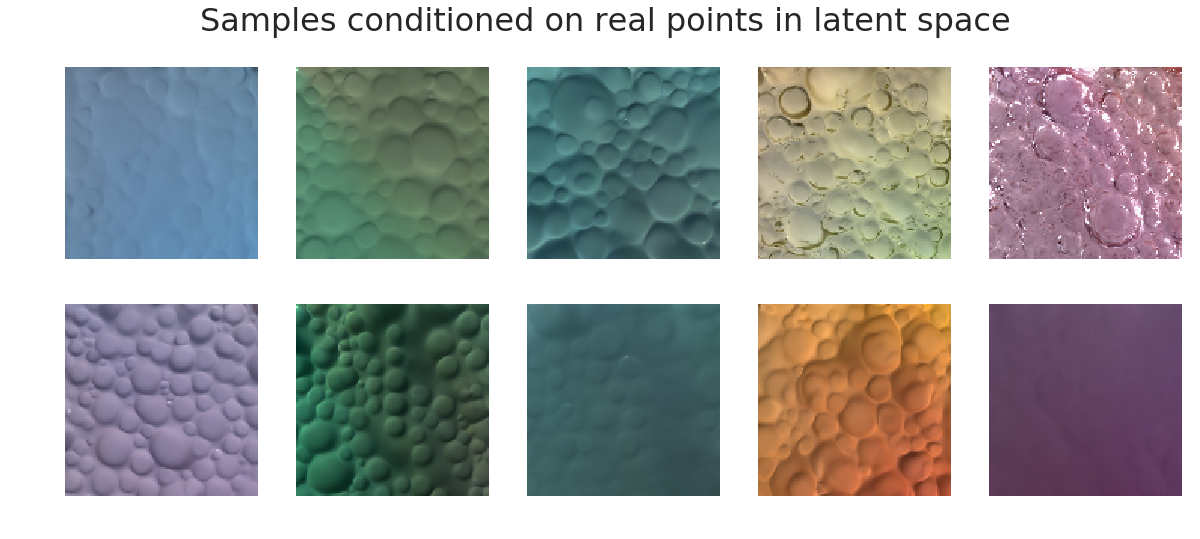

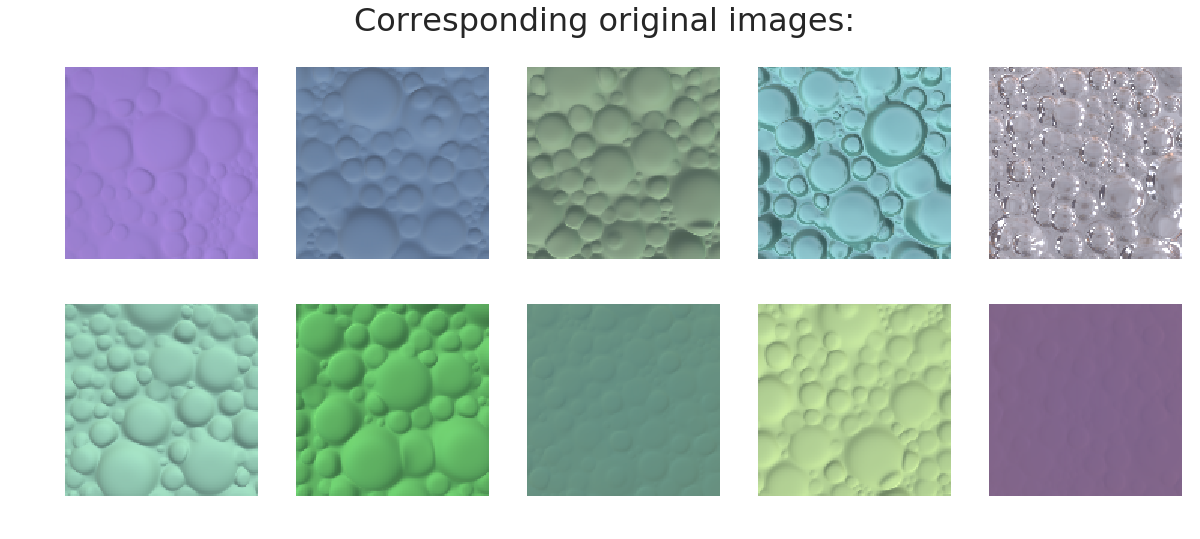

In [22]:
fig, axarr = plt.subplots(nrows=2, ncols=args.batch_size, figsize=(20,8))
fig.suptitle('Samples conditioned on real points in latent space', fontsize=32)

output_images = plotting.img_stretch(output_images)

for i in range(output_images.shape[0]):
    axarr.flatten()[i].axis('off')
    axarr.flatten()[i].imshow(output_images[i])
    
fig, axarr = plt.subplots(nrows=2, ncols=args.batch_size, figsize=(20,8))
fig.suptitle('Corresponding original images:', fontsize=32)

output_images = plotting.img_stretch(output_images)

for i in range(output_images.shape[0]):
    axarr.flatten()[i].axis('off')
    axarr.flatten()[i].imshow(train_data[i,:,:,:])    

### (b) Sample linear morph trajectories between two points corresponding to real images

In [23]:
# specify which points you want to sample
v1 = latent[0]
v2 = latent[4]
morph = [(1.0-(i/(args.batch_size-1.0)))*v1 + (i/(args.batch_size-1.0))*v2 for i in range(args.batch_size)]
latents_to_sample = np.array(morph)

In [24]:
# Cycle through latent points if too many to process at once.

output_images = np.zeros((len(latents_to_sample), args.image_size, args.image_size, 3))
batch_inds = range(0,len(latents_to_sample),args.batch_size)
for b in range(len(batch_inds)):
    g = tf.Graph()
    with g.as_default():

        h_init = tf.convert_to_tensor(latents_to_sample[batch_inds[b]:batch_inds[b]+args.batch_size], dtype=tf.float32)

        start_time = time.time()
        output_images[batch_inds[b]:batch_inds[b]+args.batch_size, :, :, :] = create_and_sample(h_init)
        end_time = time.time()
        print('Batch {} of {}, ({} images) took {} seconds.'.format(b, len(batch_inds), args.batch_size, end_time - start_time))


Creating model
('restoring parameters from', './Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/params_bumpworld_0200.ckpt')
INFO:tensorflow:Restoring parameters from ./Generalized-PixelVAE-KSbranch/model_set_Feb2019/filters-64_resnets-3_logmixes-12_latents-10_repeat-00/params_bumpworld_0200.ckpt
Generating
Batch 0 of 1, (5 images) took 196.468736887 seconds.


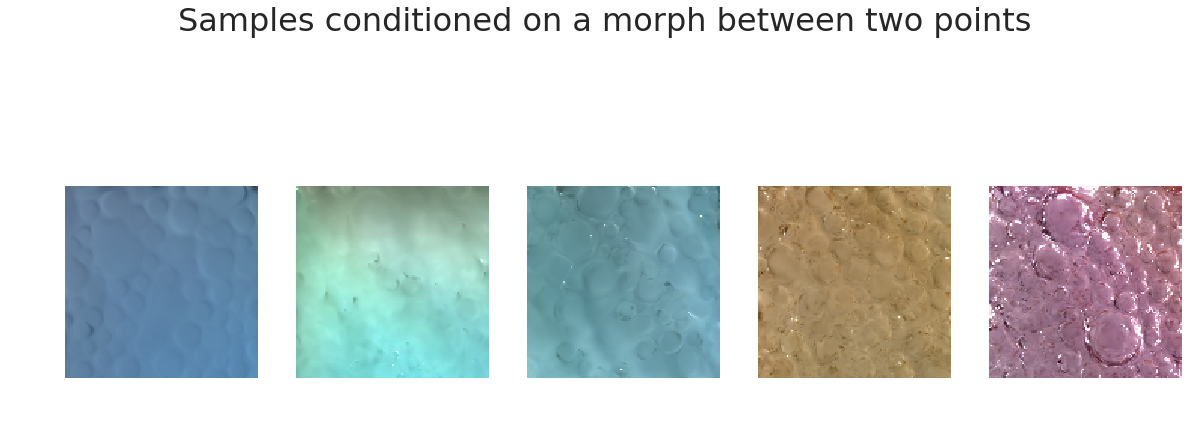

In [25]:
fig, axarr = plt.subplots(nrows=1, ncols=args.batch_size, figsize=(20,8))
fig.suptitle('Samples conditioned on a morph between two points', fontsize=32)

output_images = plotting.img_stretch(output_images)

for i in range(output_images.shape[0]):
    axarr.flatten()[i].axis('off')
    axarr.flatten()[i].imshow(output_images[i])